In [1]:
import pprint
import pandas as pd
import numpy as np
import pickle
import dask
import dask.dataframe as dd
import sklearn
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

from datetime import datetime
%matplotlib inline
# from fbprophet import Prophet

from math import sqrt
from multiprocessing import cpu_count
from joblib import Parallel
from joblib import delayed
from warnings import catch_warnings
from warnings import filterwarnings
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

from pylab import rcParams
import statsmodels.api as sm
rcParams['figure.figsize'] = 12, 6

import itertools
import seaborn as sns
from multiprocessing import Pool
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [2]:
# !pip install fbprophet

In [3]:
# display only 15 rows of results at maximum in each cell
# display all columns in each cell
pd.options.display.max_rows = 15
pd.set_option('display.max_columns', 50)

In [4]:
f = open('top_15_stores_df_master.pkl', 'rb')
df = pickle.load(f)
f.close()
df = df.set_index(['Year_Month'])

# # optimal way to open up a pickle file
# with open ('blah') as f:
#     df = pickle.load(f) #(this is the safer way)

In [5]:
df.head()

Invoice/Item Number       Date  Store Number       Store Name  \
Year_Month                                                                 
2012-01           S03392200005 2012-01-03          4578  Casey's General   
2012-01           S03390100006 2012-01-03          4571  Casey's General   
2012-01           S03388900003 2012-01-03          4540  Casey's General   
2012-01           S03338000002 2012-01-03          4590  Casey's General   
2012-01           S03398300010 2012-01-03          4543  Casey's General   

                        Address         City Zip Code  \
Year_Month                                              
2012-01            201 S 4TH ST   FARMINGTON    52626   
2012-01          100, CHERRY ST      ALLISON    50602   
2012-01     1104 N RIVERVIEW ST     BELLEVUE    52031   
2012-01            601, MAIN ST  CEDAR FALLS    50613   
2012-01      1100 EAGLE VIEW DR       MARION    52302   

                          Store Location County Number      County Category  \
Year_Month                                                                    
2012-01     POINT (-91.740069 40.639743)            89   van buren  1011100   
2012-01     POINT (-92.790457 42.745202)            12      butler  1011300   
2012-01     POINT (-90.427844 42.268432)            49     jackson  1062200   
2012-01     POINT (-92.445512 42.532963)             7  black hawk  1062300   
2012-01     POINT (-91.553462 42.037621)            57        linn  1011100   

                               Category Name Vendor Number  \
Year_Month                                                   
2012-01                     BLENDED WHISKIES           260   
2012-01                   TENNESSEE WHISKIES            85   
2012-01     PUERTO RICO & VIRGIN ISLANDS RUM            35   
2012-01                         FLAVORED RUM           370   
2012-01                     BLENDED WHISKIES           260   

                                 Vendor Name Item Number  \
Year_Month                                                 
2012-01                      Diageo Americas       25606   
2012-01             Brown-Forman Corporation       26826   
2012-01                 Bacardi U.S.A., Inc.       43126   
2012-01     Pernod Ricard USA/Austin Nichols       42716   
2012-01                      Diageo Americas       25606   

                         Item Description  Pack  Bottle Volume (ml)  \
Year_Month                                                            
2012-01       Seagrams 7 Crown Bl Whiskey    12               750.0   
2012-01     Jack Daniels Old #7 Black Lbl    12               750.0   
2012-01              Bacardi Superior Rum    12               750.0   
2012-01                Malibu Coconut Rum    12               750.0   
2012-01       Seagrams 7 Crown Bl Whiskey    12               750.0   

            State Bottle Cost  State Bottle Retail  Bottles Sold  \
Year_Month                                                         
2012-01                  6.14                 9.21          12.0   
2012-01                 13.01                19.51          12.0   
2012-01                  7.53                11.30          12.0   
2012-01                  6.90                10.35          12.0   
2012-01                  6.14                 9.21           6.0   

            Sale (Dollars)  Volume Sold (Liters)  Volume Sold (Gallons)  \
Year_Month                                                                
2012-01             110.52                   9.0                   2.38   
2012-01             234.12                   9.0                   2.38   
2012-01             135.60                   9.0                   2.38   
2012-01             124.20                   9.0                   2.38   
2012-01              55.26                   4.5                   1.19   

                        Year_Week Year_Quarter  Year  Markup Per Bottle  \
Year_Month                                                                
2012-01     2012-

In [6]:
# list the top 15 stores in the datafram
df['Store Name'].unique()

array(["Casey's General", "Sam' Club", 'Target', 'The Party Pantry',
       'Liquor Barn', "Smokin' Joe's", "Dahl's", 'Fareway Stores',
       'Central City Liquor', 'Quik Shop Foods', 'Wal-Mart', 'Kum & Go',
       'Super Saver', 'Walgreens', 'Hy-Vee'], dtype=object)

# <font color='orange'>Sales Prediction for Target Stores</font>
Take the Target stores for example to build ARIMA model for predicting potention sales/markup for the next 12 months. Business case would be predicting revenue/markup generated from each retail store brand with potential taxes collected.

## Plot Monthly and Anually Sales for Target Stores

In [7]:
df_target = df.loc[df['Store Name'] == 'Target']

In [8]:
# df_target.to_pickle('df_target.pickle')

In [9]:
# group all the columns by month for Target Store dataframe
monthly_target = df_target.groupby(['Year_Month']).sum() #dataframe for time series analysis for Fareway
monthly_target.head()

Store Number   Pack  Bottle Volume (ml)  State Bottle Cost  \
Year_Month                                                               
2012-01          3325770   8144           1010925.0            9227.11   
2012-02          3821565   9352           1149975.0           11109.98   
2012-03          3823878   9230           1187150.0           10732.28   
2012-04          3951266   9640           1221500.0           11108.29   
2012-05          4916521  12186           1452900.0           13590.67   

            State Bottle Retail  Bottles Sold  Sale (Dollars)  \
Year_Month                                                      
2012-01                13893.90        8645.0       127020.75   
2012-02                16717.18       10031.0       152527.12   
2012-03                16141.07        9882.0       144364.93   
2012-04                16750.01       10731.0       156640.50   
2012-05                20450.31       13590.0       195673.52   

            Volume Sold (Liters)  Volume Sold (Gallons)  Markup Per Bottle  \
Year_Month                                                                   
2012-01                  9235.95                2439.97            4666.79   
2012-02                 10141.77                2679.50            5607.20   
2012-03                 10443.34                2759.07            5408.79   
2012-04                 11601.99                3065.11            5641.72   
2012-05                 13536.10                3576.29            6859.64   

            Markup Per Transaction  Cost Per Transaction  Markup Rate Per Item  
Year_Month                                                                      
2012-01                   42739.53              84281.22              44939.53  
2012-02                   51134.50             101392.62              51328.49  
2012-03                   48389.71              95975.22              51365.09  
2012-04                   52770.97             103869.53              53395.62  
2012-05                   65611.98             130061.54              66217.85

In [10]:
annual_target = monthly_target.resample('A').mean()
annual_target.head()

Store Number          Pack  Bottle Volume (ml)  State Bottle Cost  \
Year_Month                                                                      
2012        4.852108e+06  11951.666667        1.424765e+06       13775.835000   
2013        4.943661e+06  12603.500000        1.388971e+06       13965.354167   
2014        4.272412e+06  10989.416667        1.216219e+06       12437.364167   
2015        4.486907e+06  11505.583333        1.277698e+06       14335.439167   
2016        3.851451e+06   9820.750000        1.128233e+06       12760.292500   

            State Bottle Retail  Bottles Sold  Sale (Dollars)  \
Year_Month                                                      
2012               20747.102500  14027.416667   213131.933333   
2013               21020.915833  13728.500000   208708.124167   
2014               18699.275833  11844.333333   187758.664167   
2015               21527.935000  12170.666667   207545.668333   
2016               19145.759167  10546.250000   176090.314167   

            Volume Sold (Liters)  Volume Sold (Gallons)  Markup Per Bottle  \
Year_Month                                                                   
2012                13950.722500            3685.989167        6971.267500   
2013                13203.414167            3488.883333        7055.561667   
2014                11401.904167            3012.743333        6261.911667   
2015                11742.752500            3102.818333        7192.495833   
2016                10129.095833            2676.462500        6385.466667   

            Markup Per Transaction  Cost Per Transaction  Markup Rate Per Item  
Year_Month                                                                      
2012                  71609.204167         141522.729167          65361.058333  
2013                  70082.013333         138626.110833          66418.851667  
2014                  62863.620833         124895.043333          57070.806667  
2015                  69321.580833         138224.087500          59642.846667  
2016                  58726.677500         117363.636667          51035.553333

In [11]:
print(type(monthly_target.index))
print(type(annual_target.index))

<class 'pandas.core.indexes.period.PeriodIndex'>
<class 'pandas.core.indexes.period.PeriodIndex'>


In [12]:
monthly_target.index = monthly_target.index.to_timestamp()
annual_target.index = annual_target.index.to_timestamp()

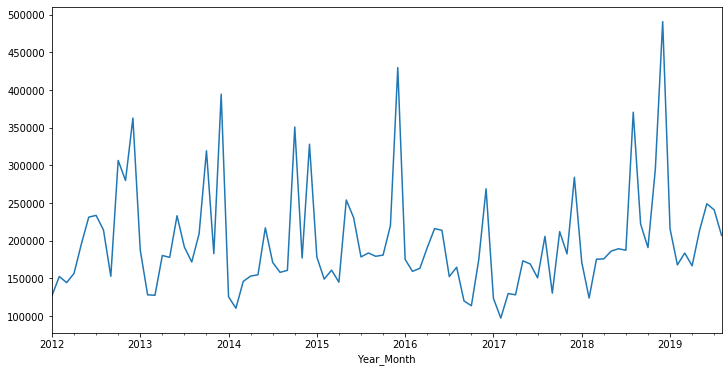

In [13]:
# target_sales_month = target_ts['Sale (Dollars)']
rcParams['figure.figsize'] = 12, 6
monthly_target['Sale (Dollars)'].plot()

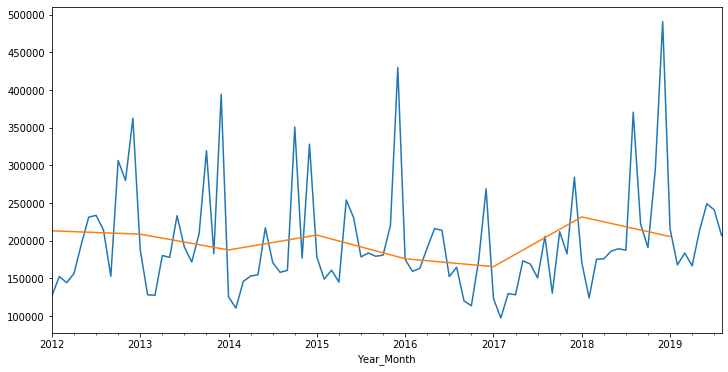

In [14]:
# plot annually and monthly sales for Target stores together
# target_sales_year = target_sales_month.resample('A').sum()
monthly_target['Sale (Dollars)'].plot();
annual_target['Sale (Dollars)'].plot();

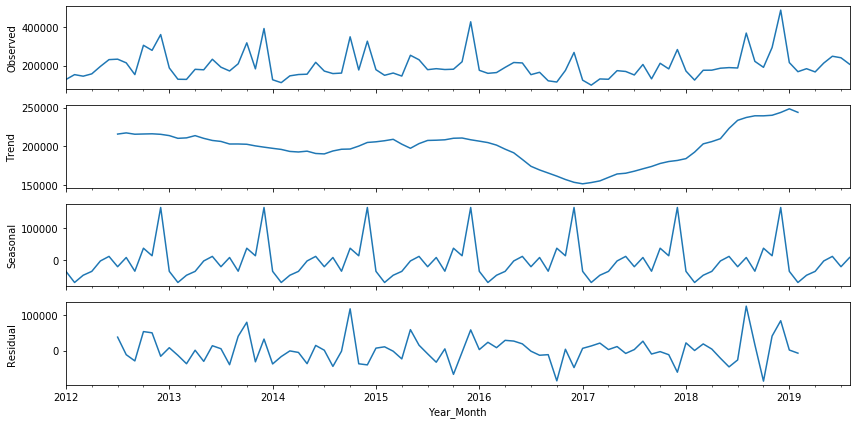

In [15]:
# visualize the monthly decomposition
decomposition = sm.tsa.seasonal_decompose(monthly_target['Sale (Dollars)'], model='additive')
fig = decomposition.plot()
fig.savefig('DeprecationWarningecomposition.png', format='png',dpi=300)

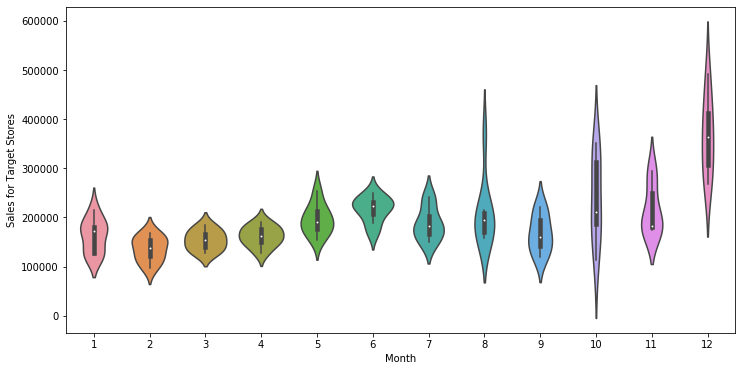

In [60]:
# violinplot months to determine variance and range
#sns.set()
sns.violinplot(x=monthly_target.index.month, y=monthly_target['Sale (Dollars)'])
plt.xlabel("Month")
plt.ylabel("Sales for Target Stores");

In [61]:
# check montly deviations for various diffs
print(monthly_target['Sale (Dollars)'].std())
print(monthly_target['Sale (Dollars)'].diff().std())
print(monthly_target['Sale (Dollars)'].diff().diff().std()) # theoretically lowest, but one above is close enough
print(monthly_target['Sale (Dollars)'].diff().diff().diff().std())

71610.7786872714
91624.88773535057
155011.1005316651
282766.822891197


In [62]:
# check annual deviations for various diffs
print(annual_target['Sale (Dollars)'].std()) # looks stationary as is
print(annual_target['Sale (Dollars)'].diff().std())
print(annual_target['Sale (Dollars)'].diff().diff().std())
print(annual_target['Sale (Dollars)'].diff().diff().diff().std())

21507.49312080974
34094.11957975544
62030.25276790286
108734.89607389065


In [63]:
# define Dickey-Fuller Test (DFT) function
import statsmodels.tsa.stattools as ts
def dftest(timeseries):
    dftest = ts.adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','Lags Used','Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    #Determine rolling statistics
    rolmean = timeseries.rolling(window=12).mean()
    rolstd = timeseries.rolling(window=12).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)

Test Statistic          -1.384950
p-value                  0.589469
Lags Used               12.000000
Observations Used       79.000000
Critical Value (1%)     -3.515977
Critical Value (5%)     -2.898886
Critical Value (10%)    -2.586694
dtype: float64


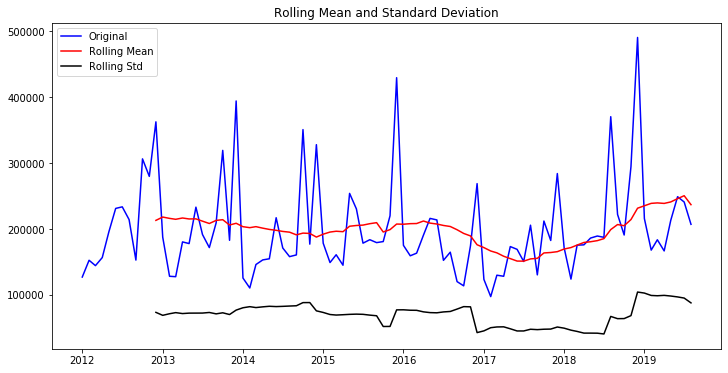

In [64]:
# run DFT on monthly
dftest(monthly_target['Sale (Dollars)'])
# p-value allows us to reject a unit root: data is stationary

Test Statistic         -2.496058
p-value                 0.116436
Lags Used               1.000000
Observations Used       6.000000
Critical Value (1%)    -5.354256
Critical Value (5%)    -3.646238
Critical Value (10%)   -2.901198
dtype: float64


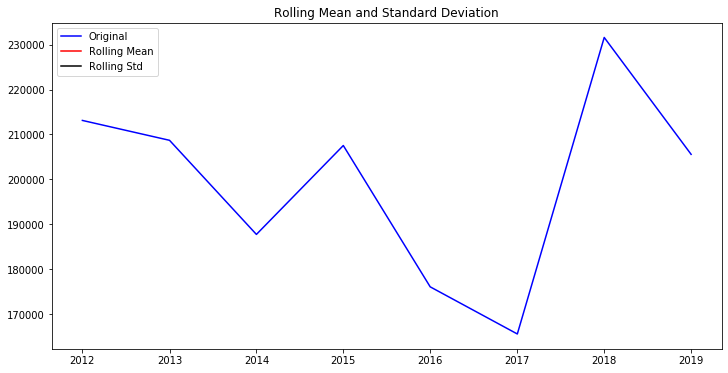

In [65]:
# run DFT on annual
dftest(annual_target['Sale (Dollars)'])

## Plot ACF and PACF

In [24]:
# define helper plot function for visualization
import statsmodels.tsa.api as smt

def plots(data, lags=None):
    layout = (4, 3)
    raw_original  = plt.subplot2grid(layout, (0, 0))
    acf_original  = plt.subplot2grid(layout, (0, 1))
    pacf_original = plt.subplot2grid(layout, (0, 2))
    
    raw_1diff  = plt.subplot2grid(layout, (1, 0))
    acf_1diff  = plt.subplot2grid(layout, (1, 1))
    pacf_1diff = plt.subplot2grid(layout, (1, 2))
    
    raw_2diff  = plt.subplot2grid(layout, (2, 0))
    acf_2diff  = plt.subplot2grid(layout, (2, 1))
    pacf_2diff = plt.subplot2grid(layout, (2, 2))
    
    raw_3diff  = plt.subplot2grid(layout, (3, 0))
    acf_3diff  = plt.subplot2grid(layout, (3, 1))
    pacf_3diff = plt.subplot2grid(layout, (3, 2))
    
    data.plot(ax=raw_original, figsize=(12, 6))
    smt.graphics.plot_acf(data, lags=lags, ax=acf_original)
    smt.graphics.plot_pacf(data, lags=lags, ax=pacf_original)
    
    data.diff().dropna().plot(ax=raw_1diff, figsize=(12, 6))
    smt.graphics.plot_acf(data.diff().dropna(), lags=lags, ax=acf_1diff)
    smt.graphics.plot_pacf(data.diff().dropna(), lags=lags, ax=pacf_1diff)
    
    data.diff().diff().dropna().plot(ax=raw_2diff, figsize=(12, 6))
    smt.graphics.plot_acf(data.diff().diff().dropna(), lags=lags, ax=acf_2diff)
    smt.graphics.plot_pacf(data.diff().diff().dropna(), lags=lags, ax=pacf_2diff)
    
    data.diff().diff().diff().dropna().plot(ax=raw_3diff, figsize=(12, 6))
    smt.graphics.plot_acf(data.diff().diff().diff().dropna(), lags=lags, ax=acf_3diff)
    smt.graphics.plot_pacf(data.diff().diff().diff().dropna(), lags=lags, ax=pacf_3diff)
    
    
    sns.despine()
    plt.tight_layout()

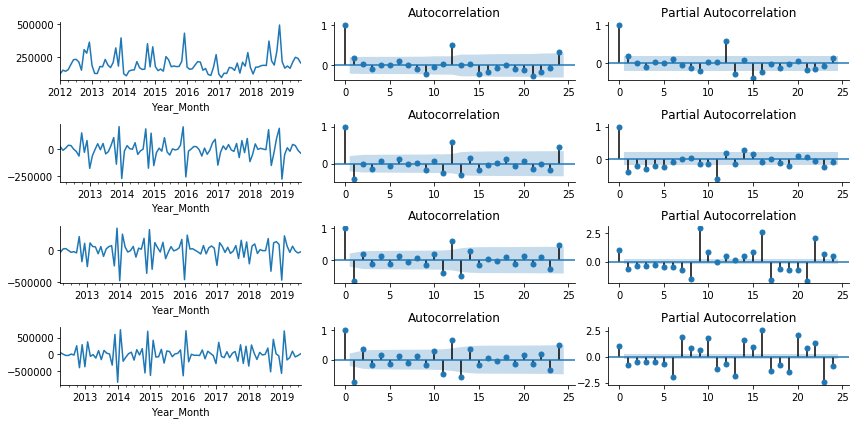

In [25]:
plots(monthly_target['Sale (Dollars)'], lags = 24)

## Sarima Model for Predicting Sales (Using Target Stores as Example)

### <font color='red'>Train-Test Split for SARIMA</font>

In [66]:
def train_test_split(df):
    '''return 80-12 train-test split data'''
    size = int(80)
    train, test = df[0:size], df[size:len(df)]
    print('Train:', len(train))
    print('Test:', len(test))
    return train, test

In [67]:
# create 66-33 train-validation-test data
# print out the lenth of train, validation,and test data
target_train, target_test = train_test_split(monthly_target['Sale (Dollars)'])

Train: 80
Test: 12


### <font color='red'>Auto Process for Searching The Best Parameters</font>
Set up combinations for order and seasonal order for SARIMA model

In [68]:
# initial parameters for p,d,q, and P,D,Q
p = d = q = range(0, 3)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter for SARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter for SARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 0, 2, 12)
SARIMAX: (0, 0, 2) x (0, 1, 0, 12)
SARIMAX: (0, 0, 2) x (0, 1, 1, 12)


### <font color='red'>Train SARIMA Model with Grid Search & Expanding Window</font>

The performance metrics I'm using will be MAE, MAPE, and RMSE. The lower the better. <br>
- MAE measures the average magnitude of the errors in a set of predictions, without considering their direction. It’s the average over the test sample of the absolute differences between prediction and actual observation where all individual differences have equal weight. <br>
- RMSE is a quadratic scoring rule that also measures the average magnitude of the error. It’s the square root of the average of squared differences between prediction and actual observation. Since the errors are squared before they are averaged, the RMSE gives a relatively high weight to large errors. This means the RMSE should be more useful when large errors are particularly undesirable. <br>
- MAPE: The mean absolute percent error (MAPE) expresses accuracy as a percentage of the error. At is the actual value and Ft is the forecast value. The difference between At and Ft is divided by the actual value At again. The absolute value in this calculation is summed for every forecasted point in time and divided by the number of fitted points n. Multiplying by 100% makes it a percentage error. If the MAPE is 5, on average, the forecast is off by 5%. <br>
 - Use to compare the fits of different time series models. Smaller values indicate a better fit. The accuracy measures are based on one-period-ahead residuals. At each point in time, the model is used to predict the Y value for the next period in time. The difference between the predicted values (fits) and the actual Y are the one-period-ahead residuals. Because of this, the accuracy measures provide an indication of the accuracy you might expect when you forecast out 1 period from the end of the data. Therefore, they do not indicate the accuracy of forecasting out more than 1 period. If you're using the model for forecasting, you shouldn't base your decision solely on accuracy measures. You should also examine the fit of the model to ensure that the forecasts and the model follow the data closely, especially at the end of the series.
 - <font color='red'>The MAPE is scale sensitive and should not be used when working with low-volume data. Notice that because "Actual" is in the denominator of the equation, the MAPE is undefined when Actual demand is zero. Furthermore, when the Actual value is not zero, but quite small, the MAPE will often take on extreme values. This scale sensitivity renders the MAPE close to worthless as an error measure for low-volume data.</font>
 - However, sometimes you may see a very large value of MAPE even though the model appears to fit the data well. Examine the plot to see if any data values are close to 0. Because MAPE divides the absolute error by the actual data, values close to 0 can greatly inflate the MAPE.

In [27]:
# auto look for best mape/mae/rsme to find the optimized parameters for fitting SARIMA model
# here should insert some explanation for error scores - combined with business explanation
model_result_list = []

for param in pdq:
    for param_seasonal in seasonal_pdq: 
        predictions = list()
        expand_window = [x for x in target_train]
        
                
        for t in range(0,len(target_test)):
            try:
                model = sm.tsa.statespace.SARIMAX(expand_window, order=param,
                                                  seasonal_order=param_seasonal,
                                                  enforce_stationarity=False,
                                                  enforce_invertibility=False)
                
                results = model.fit() # train model
                output = results.forecast() # Predicting one step into future and adding to prediction list
                yhat = output[0] 
                predictions.append(yhat)
                
                obs = target_test[t] # this is the true observed value from test set 
                expand_window.append(obs) # expanding window - the training set is expanded to include the known value 
                
        
            except: 
                continue
          
        try:
            mape = np.mean(np.abs(np.array(predictions) - np.array(target_test))/np.abs(np.array(target_test)))  # MAPE
            mae = np.mean(np.abs(np.array(predictions) - np.array(target_test))) #MAE
            rmse = np.mean((np.array(predictions) - np.array(target_test))**2)**.5  # RMSE
        except:
            mape= 9999999
            mae=  9999999
            rmse= 9999999
#         print('ARIMA{}x{} - mape:{} - mae:{} - rmse:{}'.format(param,param_seasonal,mape,mae,rmse))
        result_tuple = ('ARIMA{}x{}'.format(param,param_seasonal), mape, mae, rmse)
        model_result_list.append(result_tuple)

/home/ubuntu/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/ubuntu/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/ubuntu/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/ubuntu/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/ubuntu/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed

In [35]:
# pretty print the model parameters with corresponded error scores
pprint.pprint(model_result_list)

[('ARIMA(0, 0, 0)x(0, 0, 0, 12)', 1.0, 236958.9883333336, 251426.95665986664),
 ('ARIMA(0, 0, 0)x(0, 0, 1, 12)',
  0.5202345500953629,
  129932.51607376507,
  151749.1861158744),
 ('ARIMA(0, 0, 0)x(0, 0, 2, 12)',
  311802.8918602103,
  66955413786.87829,
  163803601987.2849),
 ('ARIMA(0, 0, 0)x(0, 1, 0, 12)',
  0.27269536701612695,
  70141.47416666689,
  92269.41911674735),
 ('ARIMA(0, 0, 0)x(0, 1, 1, 12)',
  0.24409296196426086,
  63871.96721501288,
  82163.37531286394),
 ('ARIMA(0, 0, 0)x(0, 1, 2, 12)', 9999999, 9999999, 9999999),
 ('ARIMA(0, 0, 0)x(0, 2, 0, 12)',
  0.35685464188722144,
  84243.38250000034,
  123570.98126456817),
 ('ARIMA(0, 0, 0)x(0, 2, 1, 12)',
  0.2625378516402463,
  67559.88705075491,
  92276.74705430839),
 ('ARIMA(0, 0, 0)x(0, 2, 2, 12)', 9999999, 9999999, 9999999),
 ('ARIMA(0, 0, 0)x(1, 0, 0, 12)',
  0.27859333709650064,
  72232.72588906897,
  95759.37715167347),
 ('ARIMA(0, 0, 0)x(1, 0, 1, 12)',
  0.26378349397390904,
  68783.70347459948,
  91442.92416582872),

In [39]:
# # pickle the SARIMA model results with combination of grid search and growing window
# with open('model_result_list.v1.pkl', 'wb') as f:
#     pickle.dump(model_result_list, f)

In [69]:
with open ('model_result_list.v1.pkl','rb') as f:
    model_result_list = pickle.load(f) 

In [30]:
# pretty print the model parameters with corresponded error scores
pprint.pprint(model_result_list)

[('ARIMA(0, 0, 0)x(0, 0, 0, 12)', 1.0, 236958.9883333336, 251426.95665986664),
 ('ARIMA(0, 0, 0)x(0, 0, 1, 12)',
  0.5202345500953629,
  129932.51607376507,
  151749.1861158744),
 ('ARIMA(0, 0, 0)x(0, 0, 2, 12)',
  311802.8918602103,
  66955413786.87829,
  163803601987.2849),
 ('ARIMA(0, 0, 0)x(0, 1, 0, 12)',
  0.27269536701612695,
  70141.47416666689,
  92269.41911674735),
 ('ARIMA(0, 0, 0)x(0, 1, 1, 12)',
  0.24409296196426086,
  63871.96721501288,
  82163.37531286394),
 ('ARIMA(0, 0, 0)x(0, 1, 2, 12)', 9999999, 9999999, 9999999),
 ('ARIMA(0, 0, 0)x(0, 2, 0, 12)',
  0.35685464188722144,
  84243.38250000034,
  123570.98126456817),
 ('ARIMA(0, 0, 0)x(0, 2, 1, 12)',
  0.2625378516402463,
  67559.88705075491,
  92276.74705430839),
 ('ARIMA(0, 0, 0)x(0, 2, 2, 12)', 9999999, 9999999, 9999999),
 ('ARIMA(0, 0, 0)x(1, 0, 0, 12)',
  0.27859333709650064,
  72232.72588906897,
  95759.37715167347),
 ('ARIMA(0, 0, 0)x(1, 0, 1, 12)',
  0.26378349397390904,
  68783.70347459948,
  91442.92416582872),

In [70]:
# return the best error scores with corresponed model parameters, which will be used to train the optimized model
def return_best_scores(model_result_list):
    best_mape = sorted(model_result_list, key = lambda x: x[1])
    best_mae = sorted(model_result_list, key = lambda x: x[2])
    best_rmse = sorted(model_result_list, key = lambda x: x[3])
    return best_mape[0],best_mae[0], best_rmse[0]

In [71]:
# mape, mae, rmse
return_best_scores(model_result_list)

(('ARIMA(0, 0, 1)x(2, 1, 0, 12)',
  0.16277905563608563,
  42502.37808977591,
  56213.117469264245),
 ('ARIMA(0, 0, 1)x(2, 1, 0, 12)',
  0.16277905563608563,
  42502.37808977591,
  56213.117469264245),
 ('ARIMA(0, 0, 1)x(2, 1, 0, 12)',
  0.16277905563608563,
  42502.37808977591,
  56213.117469264245))

### <font color='red'>View Model Results with The Optimized Parameter</font>
ARIMA(0, 0, 1)x(2, 1, 0, 12) - Giving Me The Best MAPE & MAE

In [72]:
sarima_1 = sm.tsa.statespace.SARIMAX(target_train,order=(0, 0, 1),seasonal_order=(2, 1, 0, 12),enforce_stationarity=False,enforce_invertibility=False)
results_1 = sarima_1.fit()
results_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                     Sale (Dollars)   No. Observations:                   80
Model:             SARIMAX(0, 0, 1)x(2, 1, 0, 12)   Log Likelihood                -540.924
Date:                            Tue, 17 Sep 2019   AIC                           1089.849
Time:                                    22:36:14   BIC                           1096.985
Sample:                                01-01-2012   HQIC                          1092.495
                                     - 08-01-2018                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.2745      0.284      0.967      0.334      -0.282       0.831
ar.S.L12      -0.4672      0.222     -2.108      0.035      -0.902      -0.033
ar.S.L24      -0.3569      0.350     -1.019      0.308      -1.043       0.329
sigma2      2.964e+09   4.52e-11   6.56e+19      0.000    2.96e+09    2.96e+09
===================================================================================
Ljung-Box (Q):                       40.55   Jarque-Bera (JB):                17.65
Prob(Q):                              0.45   Prob(JB):                         0.00
Heteroskedasticity (H):               0.91   Skew:                            -0.18
Prob(H) (two-sided):                  0.85   Kurtosis:                         6.08
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.05e+36. Standard errors may be unstable.
"""

### <font color='red'>Model Diagnose</font>
Visualize The Diagnostics Plots for Previous Model Trained on Optimized Parameters

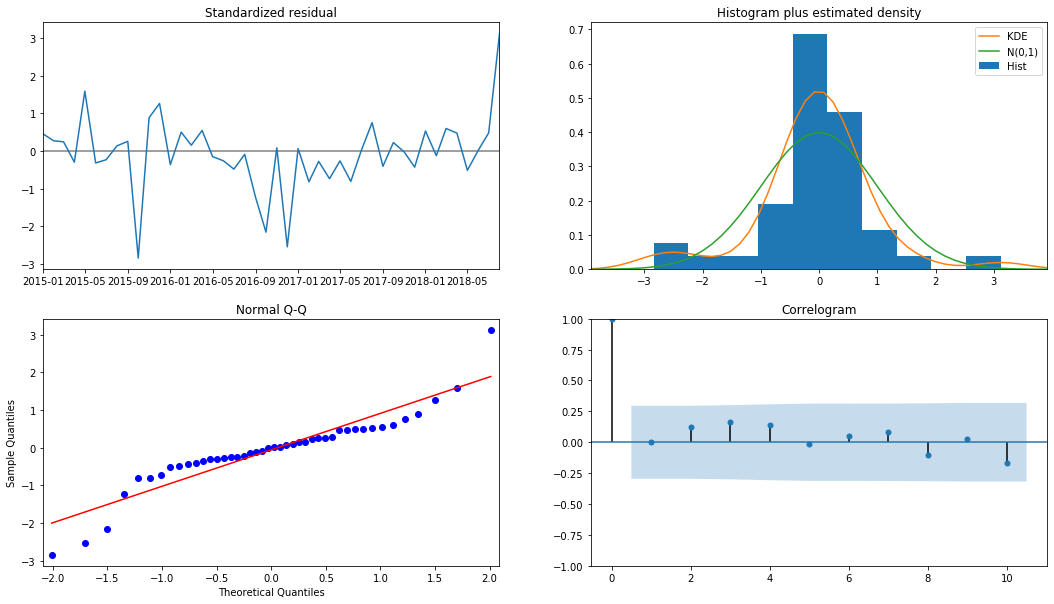

In [73]:
# plot residual diagnostics for sarima_1
# which gives me the best mape and mae
Residual = results_1.plot_diagnostics(figsize=(18, 10));
Residual.savefig('Residual Diagnostics.png', format='png',dpi=300)

### <font color='red'>Forecast Sales for The Next 12 Months</font>
Use The Most Optimized Parameter ARIMA(0, 0, 1)x(2, 1, 0, 12) to Train SARIMA Model on The Whole Dataset to Predict Sales for The Next 12 Months for Target Stores

In [74]:
# concat the train and test sets together to train the prediction model
target_all = pd.concat((target_train,target_test), axis = 0)
target_all

Year_Month
2012-01-01    127020.75
2012-02-01    152527.12
2012-03-01    144364.93
2012-04-01    156640.50
2012-05-01    195673.52
2012-06-01    231289.66
2012-07-01    233667.62
                ...    
2019-02-01    167960.04
2019-03-01    183671.92
2019-04-01    166733.76
2019-05-01    213249.48
2019-06-01    249083.64
2019-07-01    241005.72
2019-08-01    207121.68
Name: Sale (Dollars), Length: 92, dtype: float64

In [75]:
sarima_predict_12 = sm.tsa.statespace.SARIMAX(target_all,order=(0, 0, 1),seasonal_order=(2, 1, 0, 12),enforce_stationarity=False,enforce_invertibility=False)
predict_results = sarima_predict_12.fit()
predict_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                     Sale (Dollars)   No. Observations:                   92
Model:             SARIMAX(0, 0, 1)x(2, 1, 0, 12)   Log Likelihood                -689.367
Date:                            Tue, 17 Sep 2019   AIC                           1386.735
Time:                                    22:36:27   BIC                           1394.836
Sample:                                01-01-2012   HQIC                          1389.876
                                     - 08-01-2019                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.3181      0.273      1.163      0.245      -0.218       0.854
ar.S.L12      -0.5942      0.171     -3.465      0.001      -0.930      -0.258
ar.S.L24      -0.5897      0.206     -2.859      0.004      -0.994      -0.185
sigma2      3.671e+09   9.27e-12   3.96e+20      0.000    3.67e+09    3.67e+09
===================================================================================
Ljung-Box (Q):                       39.27   Jarque-Bera (JB):                14.65
Prob(Q):                              0.50   Prob(JB):                         0.00
Heteroskedasticity (H):               1.49   Skew:                            -0.22
Prob(H) (two-sided):                  0.39   Kurtosis:                         5.47
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 4.11e+36. Standard errors may be unstable.
"""

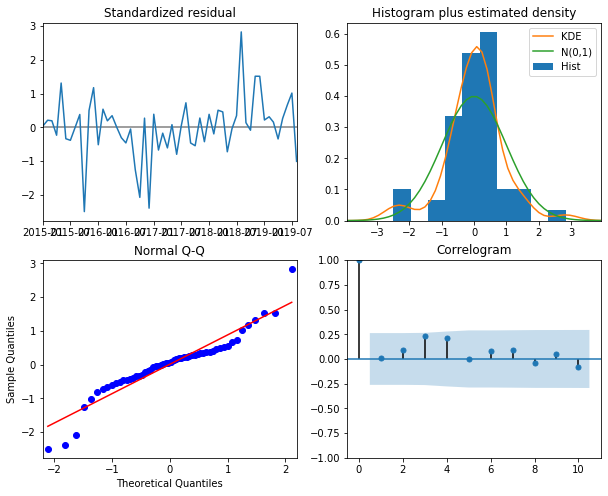

In [76]:
# plot residual diagnostics for sarima_predict_12
predict_results.plot_diagnostics(figsize=(10, 8))
plt.savefig('SARIMA Model Diagnostics Plot.png', format='png',dpi=300)

In [77]:
# predict montly sales for the next 12 months (out of time)
# from 2019 Sep to 2020 Aug
pred = predict_results.get_forecast(steps=12) 
pred_ci = pred.conf_int() # 95% confidience interval

In [78]:
# create a dataframe to view the predicted monthly sales results for the out of time 12 months
sales_2019_Sep_2020_Aug = pd.DataFrame(pred.predicted_mean)
sales_2019_Sep_2020_Aug = sales_2019_Sep_2020_Aug.rename(columns={0:'Predicted Monthly Sale'})
sales_2019_Sep_2020_Aug

Predicted Monthly Sale
2019-09-01           142169.331606
2019-10-01           145463.249122
2019-11-01           223458.245240
2019-12-01           359094.827252
2020-01-01           161177.118632
2020-02-01           126121.934866
2020-03-01           151904.478624
2020-04-01           144072.206080
2020-05-01           189586.033611
2020-06-01           201669.129062
2020-07-01           187510.136294
2020-08-01           207077.659251

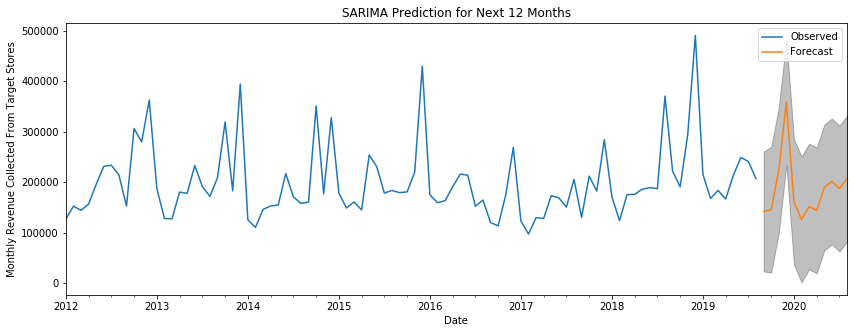

In [81]:
# plot the predicted 12 months sales (out of time)
ax = target_all.plot(label='Observed', figsize=(14,5))
pred.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Monthly Revenue Collected From Target Stores')

plt.legend()
plt.title('SARIMA Prediction for Next 12 Months')
plt.savefig('SARIMA Prediction for Next 12 Months.png', bbox_inches="tight",format='png',dpi=200)

### <font color='red'>Pickle Dataframes for Consolidating Analysis</font>

In [95]:
# pickle all known observations for future visualization
df_target_all = target_all.to_pickle('df_target_all.pickle')

In [96]:
# pickle all 12 predicted monthly sales for future visualization
sarima_sales_2019_Sep_2020_Aug = sales_2019_Sep_2020_Aug.to_pickle('sarima_sales_2019_Sep_2020_Aug.pickle')